<a href="https://colab.research.google.com/github/Alizzie/ST_CA2/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Alizzie/ST_CA2.git

Cloning into 'ST_CA2'...
remote: Enumerating objects: 18351, done.
remote: Total 18351 (delta 0), reused 0 (delta 0), pack-reused 18351
Receiving objects: 100% (18351/18351), 273.66 MiB | 14.90 MiB/s, done.
Updating files: 100% (18350/18350), done.


In [ ]:
!ls

sample_data  ST_CA2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [ ]:
datadir = 'ST_CA2/Data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
print(data.head)

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail


In [ ]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)


In [ ]:
print(data.head)

In [ ]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)

In [ ]:
centre = (bins[:-1] + bins[1:])*0.5
samples_per_bin = 250
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if bins[j] <= data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)


In [ ]:
print("Removed: ", len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print("Remaining: ", len(data))

In [ ]:
hist, bins = np.histogram(data['steering'], num_bins)
plt.bar(centre, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
# Training and Validation split
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings


In [ ]:
image_paths, steerings = load_img_steering(datadir+'/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [ ]:
print(f"Traing samples {len(X_train)}, validation samples {len(X_valid)}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins = num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins = num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(img):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(img)
  return image

In [ ]:
image = image_paths[random.randint(0, 100)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[1].imshow(zoomed_image)
axes[1].set_title("Zoomed image")

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y":(-0.1, 0.1)})
  panned_image = pan.augment_image(image)
  return panned_image

Text(0.5, 1.0, 'Panned image')

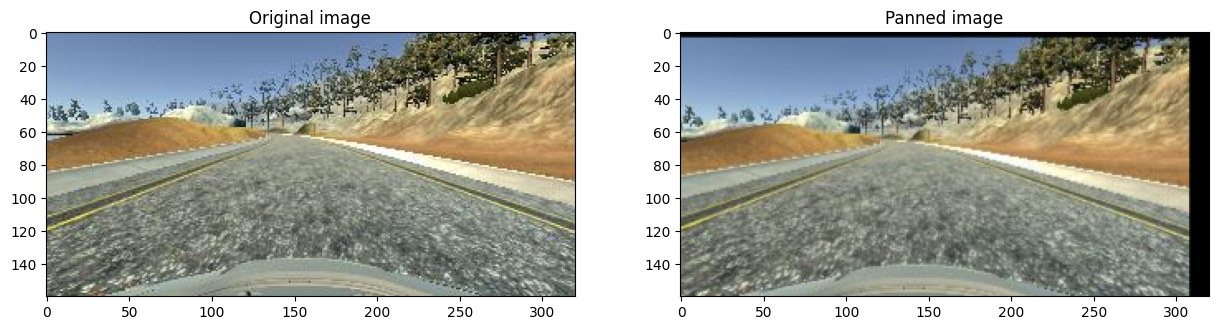

In [ ]:
image = image_paths[random.randint(0, 100)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[1].imshow(panned_image)
axes[1].set_title("Panned image")

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brighten image')

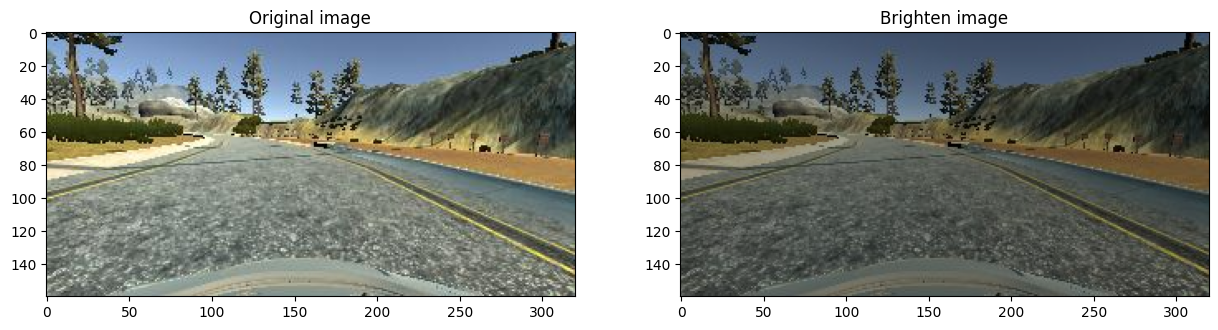

In [ ]:
image = image_paths[random.randint(0, 100)]
original_image = mpimg.imread(image)
brighten_image = img_random_brightness(original_image)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image")
axes[1].imshow(brighten_image)
axes[1].set_title("Brighten image")

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = - steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped image - Steering Angle: 0.15')

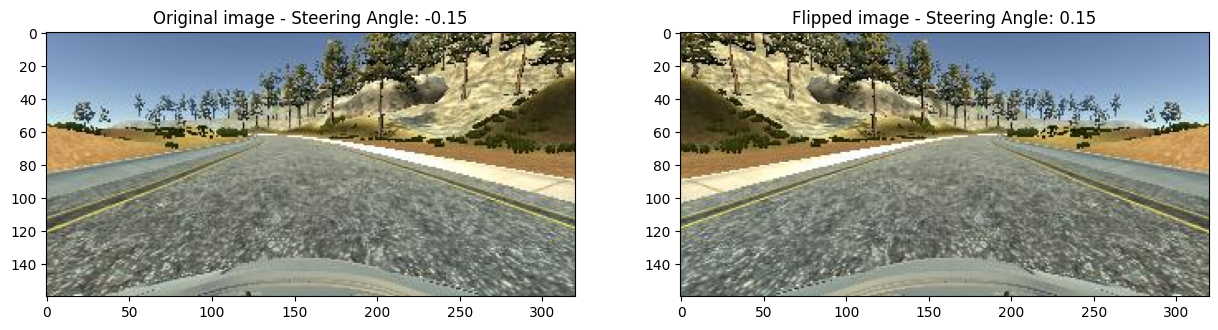

In [ ]:
random_index = random.randint(0, 100)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle  = img_random_flip(original_image, steering_angle)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_image)
axes[0].set_title("Original image - " + "Steering Angle: " + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title("Flipped image - " + "Steering Angle: " + str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

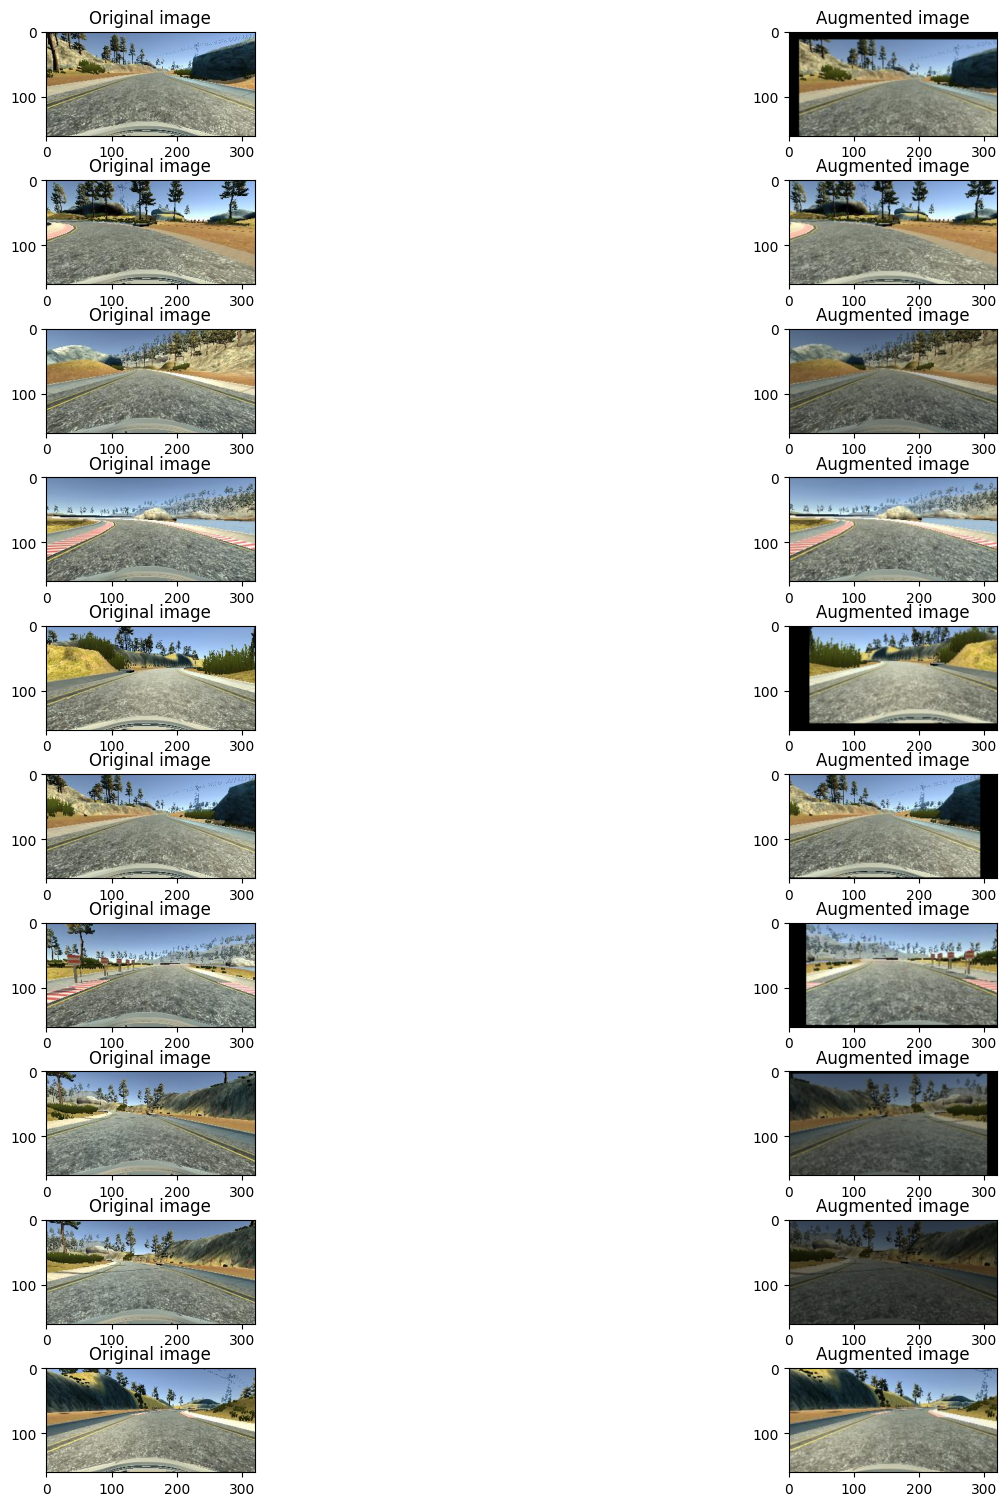

In [ ]:
nrcols = 2
nrrows = 10
fig, axes = plt.subplots(nrrows, nrcols, figsize=(15, 15))
fig.tight_layout()
for i in range(10):
  rand_num = random.randint(0, len(image_paths)-1)
  random_image = image_paths[rand_num]
  random_steering = steerings[rand_num]
  original_image = mpimg.imread(random_image)
  augmented_image, steering_angle = random_augment(random_image, random_steering)
  axes[i][0].imshow(original_image)
  axes[i][0].set_title("Original image")
  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title("Augmented image")

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [ ]:
def img_preprocess_no_imread(img):
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

In [ ]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      if is_training:
        img, steering = random_augment(image_paths[random_index], steering_angles[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        steering = steering_angles[random_index]
      img = img_preprocess_no_imread(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield(np.asarray(batch_img), np.asarray(batch_steering))


Text(0.5, 1.0, 'Preprocessed Image')

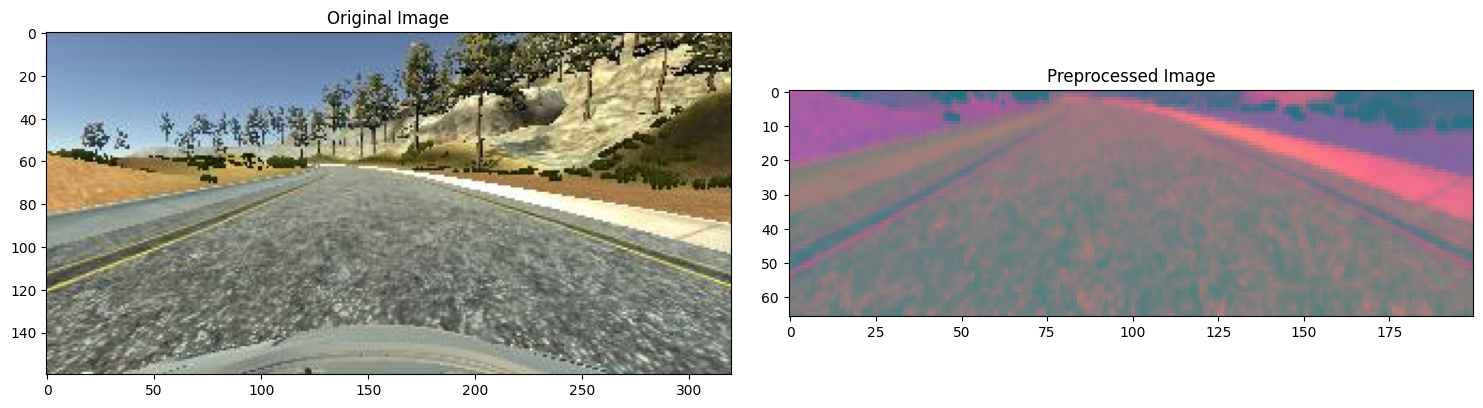

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("Preprocessed Image")


In [ ]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [ ]:
# https://arxiv.org/pdf/1604.07316v1.pdf
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(learning_rate = 0.001)
  model.compile(loss='mse', optimizer = optimizer, metrics=['mae'])
  return model


In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [ ]:
history = model.fit(
    batch_generator(X_train, y_train, batch_size=400, is_training=1),
    steps_per_epoch=300,
    epochs=30,
    validation_data=batch_generator(X_valid, y_valid, batch_size=400, is_training=0),
    validation_steps=300,
    verbose=1,
    shuffle=True
)


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('beta_model.h5')

In [ ]:
!ls
from google.colab import files
files.download('beta_model.h5')